In [3]:
%matplotlib inline

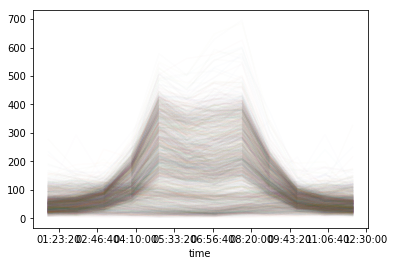

In [4]:
from jworkflow.data import get_fremont_data
data = get_fremont_data()
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
pivoted.plot(legend=False, alpha=0.01);

In [5]:
pivoted.index[:24]

Index([01:00:00, 02:00:00, 03:00:00, 04:00:00, 05:00:00, 06:00:00, 07:00:00,
       08:00:00, 09:00:00, 10:00:00, 11:00:00, 12:00:00],
      dtype='object')

In [6]:
data.index

DatetimeIndex(['2012-10-03 12:00:00', '2012-10-03 01:00:00',
               '2012-10-03 02:00:00', '2012-10-03 03:00:00',
               '2012-10-03 04:00:00', '2012-10-03 05:00:00',
               '2012-10-03 06:00:00', '2012-10-03 07:00:00',
               '2012-10-03 08:00:00', '2012-10-03 09:00:00',
               ...
               '2017-10-31 02:00:00', '2017-10-31 03:00:00',
               '2017-10-31 04:00:00', '2017-10-31 05:00:00',
               '2017-10-31 06:00:00', '2017-10-31 07:00:00',
               '2017-10-31 08:00:00', '2017-10-31 09:00:00',
               '2017-10-31 10:00:00', '2017-10-31 11:00:00'],
              dtype='datetime64[ns]', name='Date', length=44520, freq=None)

In [7]:
import numpy as np
np.unique(data.index.time)

array([datetime.time(1, 0), datetime.time(2, 0), datetime.time(3, 0),
       datetime.time(4, 0), datetime.time(5, 0), datetime.time(6, 0),
       datetime.time(7, 0), datetime.time(8, 0), datetime.time(9, 0),
       datetime.time(10, 0), datetime.time(11, 0), datetime.time(12, 0)], dtype=object)

AM & PM have been glossed over in our new function, screwing up the data visualization up above. It turns out from python http://strftime.org/, `%H` is a 24-hour clock and `%I` is a 12-hour clock. The Fremont data uses a 12 hour clock. We didn't write a unit-test to catch this.

(restarted Kernel to load code below; could have used autoreload_ext instead)

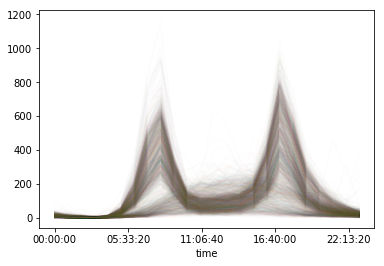

In [2]:
%matplotlib inline
from jworkflow.data import get_fremont_data
data = get_fremont_data()
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
pivoted.plot(legend=False, alpha=0.01)

---

In [3]:
pivoted.shape

(24, 1855)

In [4]:
pivoted.T.shape

(1855, 24)

Transposing, we can look at each day as a 24-hour observation; and look at how the days relate to each other. One way to look at this is to use scikit learn to do PCA to reduce the dimensionality and see how the days work together.

In [5]:
from sklearn.decomposition import PCA
PCA(2) # 2 components

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
X = pivoted.fillna(0).T.values
X.shape
# got a ValueError during PCA(2).fit(X) due to missing values
# so filling them in w/ zeros via .fillna(0)

(1855, 24)

In [15]:
X2 = PCA(2, svd_solver='full').fit_transform(X) # fit this 2 component PCA to X, return 2D trsfm

In [16]:
X2.shape

(1855, 2)

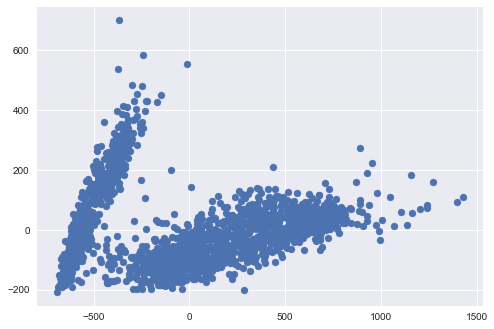

In [19]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.scatter(X2[:,0], X2[:,1])

It looks like the data is in 2 clusters. It'd be nice to automatically ID them; one way to do that is a Gaussian Mixture Model:

In [23]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2)
gmm.fit(X)
# this'll give us labels of 1/0s telling us which cluster a point is in
labels = gmm.predict(X)
labels

array([0, 0, 0, ..., 1, 0, 0])

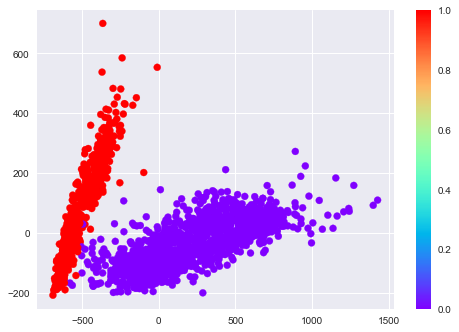

In [25]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()

One thing we may want to do is examine what's going on within the clusters. We can ask for just the portion of the data with a specific label

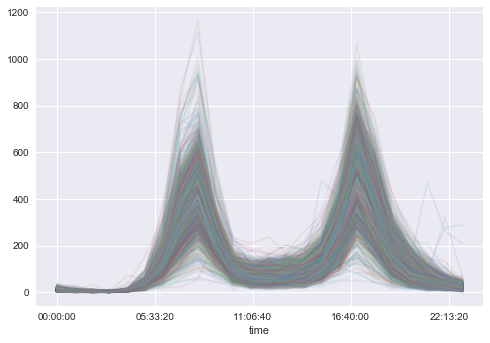

In [26]:
# here we see the 'commute' cluster of riders
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1);

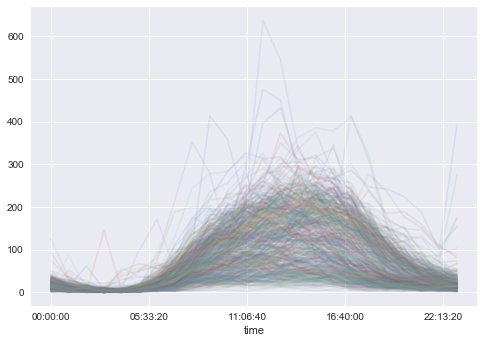

In [27]:
# and here we see the 'non-commute' cluster of riders
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1);

We can guess that the label-0 cluster corresponds to weekdays, and label-1 to weekends. Let's see how true that is. The columns of the pivoted dataset show the days, and we want to convert these dates to days of the week. The best way is to do `pd.DateTimeIndex(pivoted.columns)`

This has an attribute `.dayofweek` that gives the day of the week for each of those dates.

In [33]:
pd.DatetimeIndex(pivoted.columns).dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', length=1855)

In [37]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

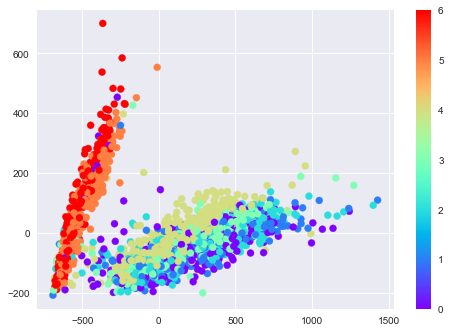

In [39]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow')
plt.colorbar()

Days 5 and 6 are Saturday and Sunday.

In [41]:
# These are all the days that are non-weekends that look like non commute days.
# Check it out: you'll see Christmass & New Year's, Thanksgiving, 4th of July, etc.
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 1) & (dayofweek < 5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29', '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', freq=None)

Just by counting bikes going across the Fremont Bridge, we've identified pretty much all of the holidays in the area -- the days when people don't work, and their bike-riding patterns match their weekend/leisure-day riding patterns.

This has very interesting implications for Physical-World Indexing. Hmmm..

If you want to know what was going on on 6 February 2017: [Seattle Times Article](https://www.seattletimes.com/seattle-news/weather/weather-service-predicts-3-to-6-inches-of-snow-in-seattle-area/)

In [20]:
import sklearn
sklearn.__version__

'0.19.1'